In [10]:
import os
import json
import pandas as pd
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf, udtf, table_function, sproc, upper, call_function, function, call_udf
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('credentials.cfg')

# Create a Python dictionary (dict) containing the names and values of the parameters for connecting to Snowflake.
#connection_parameters = dict(
#   account   =  config['SNOWPARKAZ']['SNOWFLAKE_ACCOUNT'],
#   user      =  config['SNOWPARKAZ']['SNOWFLAKE_USER'],
#   password  =  config['SNOWPARKAZ']['SNOWFLAKE_PASSWORD'],
#   role      =  config['SNOWPARKAZ']['SNOWFLAKE_ROLE'],  # optional
#   warehouse =  config['SNOWPARKAZ']['SNOWFLAKE_WAREHOUSE'],  # optional
#   database  =  config['SNOWPARKAZ']['SNOWFLAKE_DATABASE'],  # optional
#   schema    =  config['SNOWPARKAZ']['SNOWFLAKE_SCHEMA'],  # optional
#)

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

#### `Calling System-Defined Functions`

In [3]:
# The following example calls the UPPER function in the finctions module.
session.table("sample_product_data").select(upper(col("name")).alias("upper_name")).show()

----------------
|"UPPER_NAME"  |
----------------
|PRODUCT 1     |
|PRODUCT 1A    |
|PRODUCT 1B    |
|PRODUCT 2     |
|PRODUCT 2A    |
|PRODUCT 2B    |
|PRODUCT 3     |
|PRODUCT 3A    |
|PRODUCT 3B    |
|PRODUCT 4     |
----------------



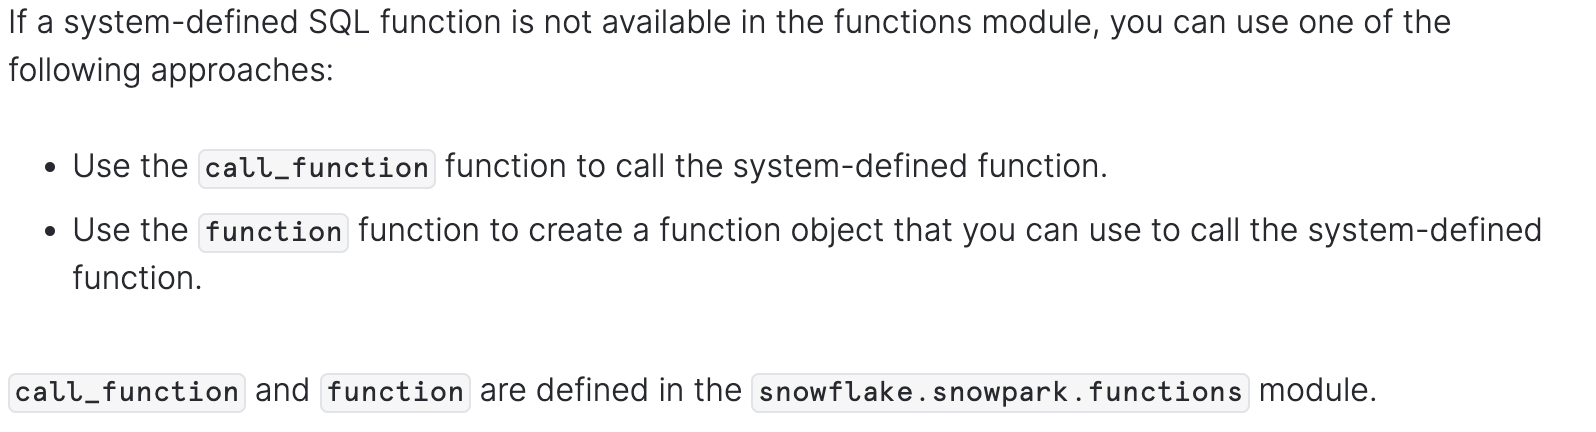

In [6]:
df = session.create_dataframe([[1,2],[3,4]], schema=["col1", "col2"])

# Call the system-defined function RADIANS() on col1
df.select(call_function("radians", col("col1"))).show()

# call_function function returns a Column, which you can pass to filter, select etc.

------------------------
|"RADIANS(""COL1"")"   |
------------------------
|0.017453292519943295  |
|0.05235987755982988   |
------------------------



In [7]:
# function: pass the name of the system-defined function, and use the returned function object to call the system-defined function

# Create a function object for the system-defined function RADIANS()
radians = function("radians")

df = session.create_dataframe([[1,2],[3,4]], schema=["col1", "col2"])
df.select(radians(col("col1"))).show()

------------------------
|"RADIANS(""COL1"")"   |
------------------------
|0.017453292519943295  |
|0.05235987755982988   |
------------------------



#### `Calling User-Defined Functions (UDFs)`

In [2]:
# Option-2
# Here is an example of how to register a named permanent UDF by setting the is_permanent argument to True:
@udf(name="minus_one", is_permanent=True, stage_location="@SF_UDF_INT_STG", replace=True)
def minus_one(x: int) -> int:
    return x - 1

In [5]:
df = session.create_dataframe([[1,2],[3,4]], schema=["col1", "col2"])
df.select(minus_one(col("col1"))).show() # Option-1

-------------------------
|"MINUS_ONE(""COL1"")"  |
-------------------------
|0                      |
|2                      |
-------------------------



In [4]:
# The following example calls the UDF function minus_one, passing in the values from the columns col1 and col2. The example passes the return value from minus_one to the select method of the DataFrame.
from snowflake.snowpark.functions import call_udf

# Run the scalar function 'minus_one' on col1 of df
df = session.create_dataframe([[1,2],[3,4]], schema=["col1", "col2"])
df.select(call_udf("minus_one", col("col1"))).show() # Option-2


-------------------------
|"MINUS_ONE(""COL1"")"  |
-------------------------
|2                      |
|0                      |
-------------------------



#### `Calling User-Defined Functions (UDFs)`

In [7]:
class GeneratorUDTF:
    def process(self, n):
        for i in range(n):
            yield(i,)

generator_udtf = udtf(GeneratorUDTF, output_schema=StructType([StructField("number", IntegerType())]), input_types=[IntegerType()])

In [8]:
session.table_function(generator_udtf(lit(3))).show()

------------
|"NUMBER"  |
------------
|0         |
|1         |
|2         |
------------



- SPLIT_TO_TABLE: https://docs.snowflake.com/en/sql-reference/functions/split_to_table
- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.table_function#snowflake.snowpark.functions.table_function

In [11]:
df = session.create_dataframe([["John","James","address1 address2 address3"]
                             ,["Mike","James","address4 address5 address6"]
                             ,["Cathy", "Stone","address4 address5 address6"]
                             ], schema=["first_name", "last_name", "address"]
                             )

In [12]:
split_to_table = table_function("split_to_table")
df.join_table_function(split_to_table(df["address"], lit(" ")).over(partition_by="last_name", order_by="first_name")).show()

----------------------------------------------------------------------------------------
|"FIRST_NAME"  |"LAST_NAME"  |"ADDRESS"                   |"SEQ"  |"INDEX"  |"VALUE"   |
----------------------------------------------------------------------------------------
|John          |James        |address1 address2 address3  |1      |1        |address1  |
|John          |James        |address1 address2 address3  |1      |2        |address2  |
|John          |James        |address1 address2 address3  |1      |3        |address3  |
|Mike          |James        |address4 address5 address6  |2      |1        |address4  |
|Mike          |James        |address4 address5 address6  |2      |2        |address5  |
|Mike          |James        |address4 address5 address6  |2      |3        |address6  |
|Cathy         |Stone        |address4 address5 address6  |3      |1        |address4  |
|Cathy         |Stone        |address4 address5 address6  |3      |2        |address5  |
|Cathy         |Stone